In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


/home/dpastorm/catkin_ws/src/bintel


In [2]:

import osqp
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt

# Discrete time model of a quadcopter
Ad = sparse.csc_matrix([
  [1.,      0.,     0., 0., 0., 0., 0.1,     0.,     0.,  0.,     0.,     0.    ],
  [0.,      1.,     0., 0., 0., 0., 0.,      0.1,    0.,  0.,     0.,     0.    ],
  [0.,      0.,     1., 0., 0., 0., 0.,      0.,     0.1, 0.,     0.,     0.    ],
  [0.0488,  0.,     0., 1., 0., 0., 0.0016,  0.,     0.,  0.0992, 0.,     0.    ],
  [0.,     -0.0488, 0., 0., 1., 0., 0.,     -0.0016, 0.,  0.,     0.0992, 0.    ],
  [0.,      0.,     0., 0., 0., 1., 0.,      0.,     0.,  0.,     0.,     0.0992],
  [0.,      0.,     0., 0., 0., 0., 1.,      0.,     0.,  0.,     0.,     0.    ],
  [0.,      0.,     0., 0., 0., 0., 0.,      1.,     0.,  0.,     0.,     0.    ],
  [0.,      0.,     0., 0., 0., 0., 0.,      0.,     1.,  0.,     0.,     0.    ],
  [0.9734,  0.,     0., 0., 0., 0., 0.0488,  0.,     0.,  0.9846, 0.,     0.    ],
  [0.,     -0.9734, 0., 0., 0., 0., 0.,     -0.0488, 0.,  0.,     0.9846, 0.    ],
  [0.,      0.,     0., 0., 0., 0., 0.,      0.,     0.,  0.,     0.,     0.9846]
])
Bd = sparse.csc_matrix([
  [0.,      -0.0726,  0.,     0.0726],
  [-0.0726,  0.,      0.0726, 0.    ],
  [-0.0152,  0.0152, -0.0152, 0.0152],
  [-0.,     -0.0006, -0.,     0.0006],
  [0.0006,   0.,     -0.0006, 0.0000],
  [0.0106,   0.0106,  0.0106, 0.0106],
  [0,       -1.4512,  0.,     1.4512],
  [-1.4512,  0.,      1.4512, 0.    ],
  [-0.3049,  0.3049, -0.3049, 0.3049],
  [-0.,     -0.0236,  0.,     0.0236],
  [0.0236,   0.,     -0.0236, 0.    ],
  [0.2107,   0.2107,  0.2107, 0.2107]])
[nx, nu] = Bd.shape

# Constraints
u0 = 10.5916 # Hover Thrust
umin = np.ones(nu)*9.6 - u0
umax = np.ones(nu)*11.0 - u0
xmin = np.array([-np.pi/6,-np.pi/6,-np.inf,-np.inf,-np.inf,-1.,
                 -np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf])
xmax = np.array([ np.pi/6, np.pi/6, np.inf, np.inf, np.inf, np.inf,
                  np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

# Sizes
ns = 12
nu = 4

# Objective function
Q = sparse.diags([0., 0., 10., 10., 10., 10., 0., 0., 0., 5., 5., 5.])
QN = Q
R = 0.1*sparse.eye(nu)


In [3]:

# Initial and reference states
x0 = np.zeros(ns)
xr = np.array([0.,0.,4.,0.,0.,0.,0.,0.,0.,0.,0.,0.])

# Prediction horizon
N = 10

# Cast MPC problem to a QP: x = (x(0),x(1),...,x(N),u(0),...,u(N-1))
# - quadratic objective
P = sparse.block_diag([sparse.kron(sparse.eye(N), Q), QN,
                       sparse.kron(sparse.eye(N), R)]).tocsc()
# - linear objective
q = np.hstack([np.kron(np.ones(N), -Q.dot(xr)), -QN.dot(xr),
               np.zeros(N*nu)])
# - linear dynamics
Ax = sparse.kron(sparse.eye(N+1),-sparse.eye(nx)) + sparse.kron(sparse.eye(N+1, k=-1), Ad)
Bu = sparse.kron(sparse.vstack([sparse.csc_matrix((1, N)), sparse.eye(N)]), Bd)
Aeq = sparse.hstack([Ax, Bu])
leq = np.hstack([-x0, np.zeros(N*nx)])
ueq = leq
# - input and state constraints
Aineq = sparse.eye((N+1)*nx + N*nu)
lineq = np.hstack([np.kron(np.ones(N+1), xmin), np.kron(np.ones(N), umin)])
uineq = np.hstack([np.kron(np.ones(N+1), xmax), np.kron(np.ones(N), umax)])
# - OSQP constraints
A = sparse.vstack([Aeq, Aineq]).tocsc()
l = np.hstack([leq, lineq])
u = np.hstack([ueq, uineq])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace
prob.setup(P, q, A, l, u, warm_start=True)

# Simulate in closed loop
nsim = 40

# Store data Init
xst = np.zeros((ns,nsim))
ust = np.zeros((nu,nsim))


for i in range(nsim):
    # Solve
    res = prob.solve()

    # Check solver status
    if res.info.status != 'solved':
        raise ValueError('OSQP did not solve the problem!')

    # Apply first control input to the plant
    ctrl = res.x[-N*nu:-(N-1)*nu]
    x0 = Ad.dot(x0) + Bd.dot(ctrl)

    # Store Data
    xst[:,i] = x0
    ust[:,i] = ctrl

    # Update initial state
    l[:nx] = -x0
    u[:nx] = -x0
    prob.update(l=l, u=u)


-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 172, constraints m = 304
          nnz(P) + nnz(A) = 1161
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off

iter   objective    pri res    dua res    rho        time
   1  -5.0309e+02   3.75e+00   2.40e+01   1.00e-01   4.23e-04s
  50  -3.9282e+02   9.20e-04   1.06e-03   1.00e-01   1.08e-03s

status:               solved
number of iterations: 50
optima

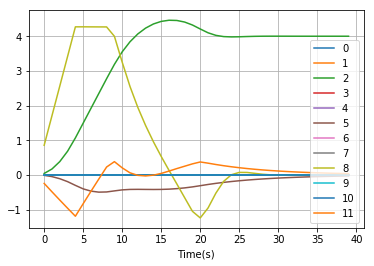

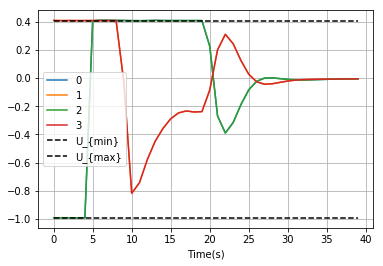

In [4]:
for i in range(ns):
  plt.plot(range(nsim),xst[i,:],label=str(i))
plt.xlabel('Time(s)')
plt.grid()
plt.legend()
plt.show()    


for i in range(nu):
  plt.plot(range(nsim),ust[i,:],label=str(i))
plt.plot(range(nsim),np.ones(nsim)*umin[1],label='U_{min}',linestyle='dashed', linewidth=1.5, color='black')
plt.plot(range(nsim),np.ones(nsim)*umax[1],label='U_{max}',linestyle='dashed', linewidth=1.5, color='black')
plt.xlabel('Time(s)')
plt.grid()
plt.legend()
plt.show()  